In [2]:
from algo.cql import CQLSAC
import pandas as pd
import numpy as np
import data_preprocessing as dp
import mdp
import data_preprocessing as dp
import Replay_Buffer
import torch as T
import numpy as np
import random
import reward
import matplotlib.pyplot as plt
import math
import osmnx as ox
import matplotlib.animation as animation
from matplotlib.image import imread

In [3]:
url_FT_train = 'INTERACTION/DR_USA_Roundabout_FT_train.csv'
df_eval = pd.read_csv(url_FT_train)

# add a new label unique_id using case_id and track_id
df_eval['unique_id'] = df_eval['case_id'].astype(int) * 100+ df_eval['track_id']

# change length, width and psi_rad from NaN to 0 for pedestrain/bicycle
df_eval.loc[df_eval['agent_type'] == 'pedestrian/bicycle', 'length'] = 0
df_eval.loc[df_eval['agent_type'] == 'pedestrian/bicycle', 'width'] = 0
df_eval.loc[df_eval['agent_type'] == 'pedestrian/bicycle', 'psi_rad'] = 0


### important!!!
# agent_type pedestrain/bicycle = -1
# agent_type car = 1
df_eval.loc[df_eval['agent_type'] == 'pedestrian/bicycle', 'agent_type'] = -1
df_eval.loc[df_eval['agent_type'] == 'car', 'agent_type'] = 1

df_train_small = df_eval[df_eval['case_id'] <= 100]

uniqueTracks = dp.read_uniqueTracks(df_train_small)

v_max = max(df_train_small['vx']**2 + df_train_small['vy']**2) ** 0.5

In [4]:
df_train_small

,case_id,track_id,frame_id,timestamp_ms,agent_type,x,y,vx,vy,psi_rad,length,width,unique_id
0,1.0,1,1,100,-1,1044.509,1012.175,0.103,-1.005,0.000,0.00,0.00,101
1,1.0,2,1,100,-1,1043.840,1013.348,-0.101,-1.362,0.000,0.00,0.00,102
2,1.0,3,1,100,-1,1007.638,1022.038,0.687,0.787,0.000,0.00,0.00,103
3,1.0,4,1,100,1,1036.888,976.415,-1.063,1.980,2.064,5.20,1.86,104
4,1.0,5,1,100,1,1038.206,993.477,-2.343,5.161,1.997,4.68,1.90,105
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39091,100.0,6,40,4000,1,1029.664,992.219,5.441,4.154,0.652,4.54,1.85,10006
39092,100.0,8,40,4000,1,1045.223,982.782,-1.040,0.741,2.522,6.40,2.21,10008
39093,100.0,9,40,4000,1,996.424,985.742,6.600,-0.103,-0.016,4.73,1.91,10009
39094,100.0,10,40,4000,1,1043.018,1007.662,0.000,0.000,3.105,6.01,2.30,10010


In [5]:
timestamp = df_train_small['timestamp_ms'].reset_index(drop=True)

In [6]:
def get_next_pos_pred(ego_x, ego_y, ego_heading, ego_vx, ego_vy):
    vehicle_speed = (ego_vx ** 2 + ego_vy ** 2) ** 0.5
    next_point_pos_x = ego_x + (vehicle_speed * math.cos(ego_heading))/5
    next_point_pos_y = ego_y + (vehicle_speed * math.sin(ego_heading))/5
    next_point_pos = (next_point_pos_x, next_point_pos_y)

    return [next_point_pos_x, next_point_pos_y]

In [7]:
# Parameters to be passed
random.seed(42)
T.manual_seed(42)
np.random.seed(42)
state_dim = 37
action_dim = 2
max_action = 40
device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [8]:
# Replay Buffer to be used to train
replay_buffer = Replay_Buffer.ReplayBuffer(state_dim, action_dim, device, 2000)
replay_buffer.load(f"buffers/DR_USA_Roundabout_FT")
#train_timesteps = 100000

In [9]:
# Calling SAC-CQL
policy = CQLSAC(state_dim, action_dim, device)

In [10]:
actor_loss = []
critic_loss = []
q_val =[]
training_iters = 0
rewards = []

In [11]:
%%time
for epoch in range(20):
    for itr in range(50):
        info = policy.train(replay_buffer, batch_size = 32)        
        actor_loss.append(info['actor_loss'])
        critic_loss.append(info['critic_loss'])
        q_val.append(info['q_val'])
        training_iters += 1
    

CPU times: total: 14.6 s
Wall time: 32.4 s


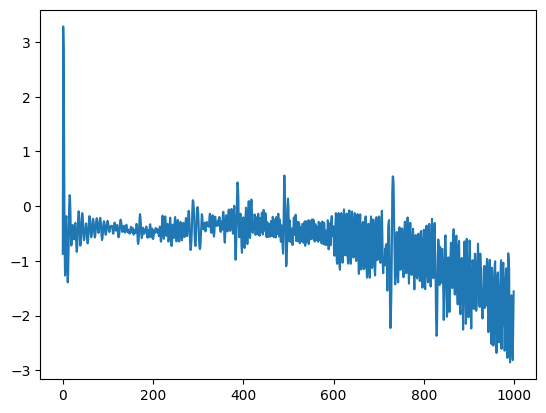

In [12]:
plt.plot(q_val)

Text(0, 0.5, 'Q-value estimation')

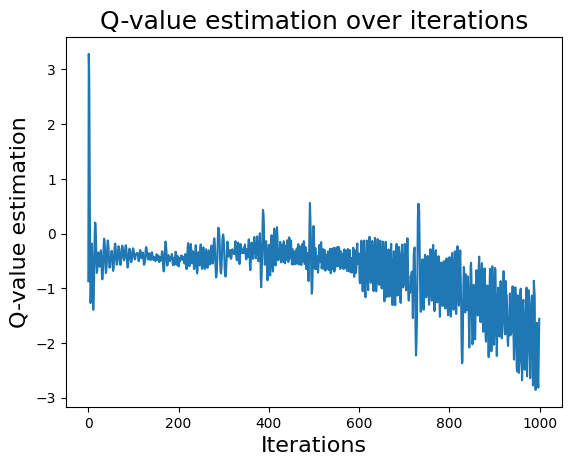

In [13]:
plt.plot(q_val[0:15000])
plt.title("Q-value estimation over iterations", fontsize=18)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Q-value estimation", fontsize=16)

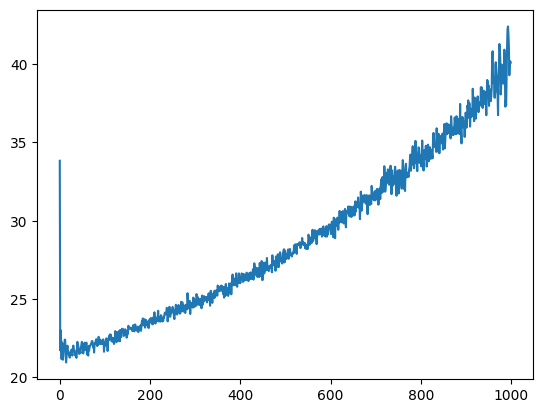

In [14]:
plt.plot(actor_loss[0:20000])

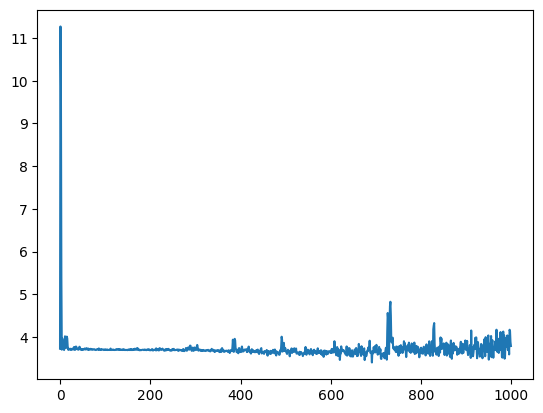

In [15]:
plt.plot(critic_loss[0:15000])

## Evaluating Agent

In [16]:
val_data = 'INTERACTION/DR_USA_Roundabout_FT_val.csv'
val_df = pd.read_csv(val_data)

# add a new label unique_id using case_id and track_id
val_df['unique_id'] = val_df['case_id'].astype(int) * 100+ val_df['track_id']

# change length, width and psi_rad from NaN to 0 for pedestrain/bicycle
val_df.loc[val_df['agent_type'] == 'pedestrian/bicycle', 'length'] = 0
val_df.loc[val_df['agent_type'] == 'pedestrian/bicycle', 'width'] = 0
val_df.loc[val_df['agent_type'] == 'pedestrian/bicycle', 'psi_rad'] = 0


### important!!!
# agent_type pedestrain/bicycle = -1
# agent_type car = 1
val_df.loc[val_df['agent_type'] == 'pedestrian/bicycle', 'agent_type'] = -1
val_df.loc[val_df['agent_type'] == 'car', 'agent_type'] = 1

v_max = v_max = max(val_df['vx']**2 + val_df['vy']**2) ** 0.5
uniqueTracks_test = dp.read_uniqueTracks(val_df)

In [25]:
def euclidean_distance(x, y, x1, y1):
    # Calculate the difference between the coordinates
    diff_x = x - x1
    diff_y = y - y1
    
    # Calculate the Euclidean distance
    distance = math.sqrt(diff_x**2 + diff_y**2)
    
    return distance

def calculate_miss_rate(predicted_x, predicted_y, true_x, true_y, threshold=2.0):
    # Calculate the Euclidean distance for the final points
    final_distance = euclidean_distance(predicted_x[-1], predicted_y[-1], true_x[-1], true_y[-1])
    # Check if the distance is greater than the threshold
    miss = int(final_distance > threshold)
    return miss

def calculate_ade(predicted_x, predicted_y, true_x, true_y):
    # Calculate Euclidean distances for all corresponding points and then take the average
    total_distance = 0
    for px, py, tx, ty in zip(predicted_x, predicted_y, true_x, true_y):
        distance = euclidean_distance(px, py, tx, ty)
        total_distance += distance
    average_distance = total_distance / len(predicted_x)
    return average_distance

In [26]:
FDE_case = []
FDE_min = []
FDE_mean = []

ADE_case = []
ADE_min = []
ADE_mean = []

MR_case = []
MR_min = []
MR_mean = []
threshold = 2.0  # Define a suitable threshold for MR


In [42]:
for case_id in  val_df['case_id']:
    for ego in val_df[val_df['case_id']==case_id].unique_id:
        if val_df[val_df['unique_id']==ego].agent_type.unique() == 1:
            timestep = val_df[val_df['unique_id']==ego].timestamp_ms
            timestep = timestep.reset_index(drop=True)

            other_agents, interactive_agents = mdp.get_other_agents_unique_id(ego, timestep[0], uniqueTracks_test)
            mdp_tuple = mdp.get_mdp_tuple(ego, interactive_agents, timestep[0], uniqueTracks_test, v_max)
            s, a, r, s_next, the_last_episode = mdp_tuple
            x = [s[4]]
            y= [s[5]]
            expected_x = [val_df[(val_df['unique_id']==ego) & (val_df['timestamp_ms']==0)].x]
            expected_y = [val_df[(val_df['unique_id']==ego) & (val_df['timestamp_ms']==0)].y]
            x1 = [s[13]]
            y1 = [s[14]]
            x2 = [s[21]]
            y2 = [s[22]]
            x3 = [s[30]]
            y3 = [s[31]]
            for current_time in timestep[1:]:
                vx,vy = policy.select_action(np.array(s))
                new_x,new_y = get_next_pos_pred(s[4],s[5],s[8],vx,vy)
                x.append(new_x)
                y.append(new_y)
                other_agents, interactive_agents = mdp.get_other_agents_unique_id(ego, current_time, uniqueTracks_test)
                mdp_tuple = mdp.get_mdp_tuple(ego, interactive_agents, current_time, uniqueTracks_test, v_max)
                if not not mdp_tuple:
                    s, a, r, s_next, the_last_episode = mdp_tuple
                s[4] = new_x
                s[5] = new_y
                s[6] = vx
                s[7] = vy
                x1.append(s[13])
                y1.append(s[14])
                x2.append(s[21])
                y2.append(s[22])
                x3.append(s[30])
                y3.append(s[31])
                expected_x.append(val_df[(val_df['unique_id']==ego) & (val_df['timestamp_ms']==current_time)].x.values[0])
                expected_y.append(val_df[(val_df['unique_id']==ego) & (val_df['timestamp_ms']==current_time)].y.values[0])
                
            FDE = euclidean_distance(x[-1],y[-1],expected_x[-1],expected_y[-1])
            FDE_case.append(FDE)

            ADE = calculate_ade(x, y, expected_x,expected_y)
            ADE_case.append(ADE)

            MR = calculate_miss_rate(x, y, expected_x, expected_y)
            MR_case.append(MR)
            
    FDE_mean = np.array(FDE_case).min()
    ADE_mean = np.array(ADE.case).min()
    MR_mean = np.array(MR_case).min()
    FDE_min.append(FDE_mean)
    ADE_min.append(ADE_mean)
    MR_min.append(MR_min)


c:\Users\dylan\Desktop\EECS-545\EECS-545-final-project\EECS-545-final-project-ignore_rv_rp - Copy\reward.py:119: RuntimeWarning: invalid value encountered in arccos
  if rotated_rectangles_intersect(((ego_x, ego_y), 0.95 * ego_length, 0.95 * ego_width, np.arccos(ego_psi)),
c:\Users\dylan\Desktop\EECS-545\EECS-545-final-project\EECS-545-final-project-ignore_rv_rp - Copy\reward.py:120: RuntimeWarning: invalid value encountered in arccos
  ((interactive_x, interactive_y), 0.95 * interactive_length, 0.95 * interactive_width, np.arccos(interactive_psi))):


rv = 0.28878418564007313, rc = 0, rp = -12.203640768229745
rv = 0.2873689781026699, rc = 0, rp = -12.220341893744262
rv = 0.2860239634305904, rc = 0, rp = -12.24729325198013
rv = 0.2848153364679774, rc = 0, rp = -12.283790375938516
rv = 0.28371322797701437, rc = 0, rp = -12.330144200292281
rv = 0.28267094982139684, rc = 0, rp = -12.382130713249746
rv = 0.2816972113083995, rc = 0, rp = -12.440034244325894
rv = 0.28075513798132845, rc = 0, rp = -12.504193896449431
rv = 0.27982507280820196, rc = 0, rp = -12.571341416094146
rv = 0.27893390916333516, rc = 0, rp = -12.642298604288804
rv = 0.27806107753735715, rc = 0, rp = 0.0
rv = 0.2771708213777404, rc = 0, rp = 0.0
rv = 0.27635412520413366, rc = 0, rp = 0.0
rv = 0.27557619378384424, rc = 0, rp = 0.0
rv = 0.2748653506832526, rc = 0, rp = 0.0
rv = 0.2742523782624459, rc = 0, rp = 0.0
rv = 0.27374969222643414, rc = 0, rp = 0.0
rv = 0.27332419863431084, rc = 0, rp = 0.0
rv = 0.27302566040364423, rc = 0, rp = 0.0
rv = 0.2727708865754569, rc = 0

TypeError: cannot convert the series to <class 'float'>

In [ ]:
np.array(FDE_min).min()
np.array(ADE_min).min()
np.array(MR_min).min()

[0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966,
 0.3176509658142966]

## Underlying movement of ego 101

In [ ]:
val_data = 'INTERACTION/DR_USA_Roundabout_FT_val.csv'
val_df = pd.read_csv(val_data)

# add a new label unique_id using case_id and track_id
val_df['unique_id'] = val_df['case_id'].astype(int) * 100+ val_df['track_id']

# change length, width and psi_rad from NaN to 0 for pedestrain/bicycle
val_df.loc[val_df['agent_type'] == 'pedestrian/bicycle', 'length'] = 0
val_df.loc[val_df['agent_type'] == 'pedestrian/bicycle', 'width'] = 0
val_df.loc[val_df['agent_type'] == 'pedestrian/bicycle', 'psi_rad'] = 0


### important!!!
# agent_type pedestrain/bicycle = -1
# agent_type car = 1
val_df.loc[val_df['agent_type'] == 'pedestrian/bicycle', 'agent_type'] = -1
val_df.loc[val_df['agent_type'] == 'car', 'agent_type'] = 1

v_max = v_max = max(val_df['vx']**2 + val_df['vy']**2) ** 0.5
uniqueTracks_test = dp.read_uniqueTracks(val_df)

In [ ]:
val_df[val_df['unique_id']==10202]

,case_id,track_id,frame_id,timestamp_ms,agent_type,x,y,vx,vy,psi_rad,length,width,unique_id
44608,102.0,2,1,100,1,1024.572,988.596,5.963,3.033,0.471,4.4,1.83,10202
44617,102.0,2,2,200,1,1025.153,988.929,5.896,3.198,0.497,4.4,1.83,10202
44626,102.0,2,3,300,1,1025.726,989.277,5.824,3.355,0.523,4.4,1.83,10202
44635,102.0,2,4,400,1,1026.292,989.639,5.748,3.502,0.547,4.4,1.83,10202
44644,102.0,2,5,500,1,1026.851,990.014,5.668,3.637,0.571,4.4,1.83,10202
44653,102.0,2,6,600,1,1027.403,990.401,5.587,3.759,0.592,4.4,1.83,10202
44662,102.0,2,7,700,1,1027.947,990.798,5.504,3.868,0.613,4.4,1.83,10202
44671,102.0,2,8,800,1,1028.484,991.204,5.424,3.962,0.631,4.4,1.83,10202
44680,102.0,2,9,900,1,1029.014,991.617,5.346,4.042,0.647,4.4,1.83,10202
44689,102.0,2,10,1000,1,1029.537,992.036,5.273,4.109,0.662,4.4,1.83,10202


In [ ]:
other_agents, interactive_agents = mdp.get_other_agents_unique_id(10202, 100, uniqueTracks_test)
mdp_tuple = mdp.get_mdp_tuple(10202, interactive_agents, 100, uniqueTracks_test, v_max)
s, a, r, s_next, the_last_episode = mdp_tuple
interactive_agents

/Users/shitanshubhushan/Documents/EECS-545-final-project/reward.py:163: RuntimeWarning: invalid value encountered in arccos
  alpha = np.arccos((distance_next**2 + distance_closest**2 - distance_next_closest**2)/(2*distance_next*distance_closest))
/Users/shitanshubhushan/Documents/EECS-545-final-project/reward.py:120: RuntimeWarning: invalid value encountered in arccos
  ((interactive_x, interactive_y), 0.95 * interactive_length, 0.95 * interactive_width, np.arccos(interactive_psi))):


[10204, 10201, 10203]

In [ ]:
#data = val_df[val_df['unique_id'] == 404]
#data2 = val_df[val_df['unique_id'] == 403]
#data3 = val_df[val_df['unique_id'] == 405]
#data4 = val_df[val_df['unique_id'] == 415]

data = val_df[val_df['unique_id'] == 10202]
data2 = val_df[val_df['unique_id'] == 10204]
data3 = val_df[val_df['unique_id'] == 10201]
data4 = val_df[val_df['unique_id'] == 10203]
#data5 = df_train_small[df_train_small['unique_id'] == 606]

fig, ax = plt.subplots()

#background_image = imread('INTERACTION/map.png')

# Display the image on the plot
#ax.imshow(background_image, extent=[950, 1060, 950, 1020])

xdata, ydata = [], []
xdata2, ydata2 = [], []
xdata3, ydata3 = [], []
xdata4, ydata4 = [], []
#xdata5, ydata5 = [], []
ln, = plt.plot([], [], 'ro')  # 'ro' 表示紅色的圓點
ln2, = plt.plot([], [], 'bo')
ln3, = plt.plot([], [], 'bo')
ln4, = plt.plot([], [], 'bo')
#ln5, = plt.plot([], [], 'rs')

def init():
    ax.set_xlim(950, 1060)  # 根據數據的 x 值範圍設定
    ax.set_ylim(950, 1020)  # 根據數據的 y 值範圍設定
    return ln, ln2, ln3, ln4#, ln5

def update(frame):
    xdata.append(data.iloc[frame]['x'])
    ydata.append(data.iloc[frame]['y'])
    ln.set_data(xdata, ydata)

    if frame < len(data2):
        xdata2.append(data2.iloc[frame]['x'])
        ydata2.append(data2.iloc[frame]['y'])
        ln2.set_data(xdata2, ydata2)
    else:
        ln2.set_data(xdata2, ydata2)
    #'''
    if frame < len(data3):
        xdata3.append(data3.iloc[frame]['x'])
        ydata3.append(data3.iloc[frame]['y'])
        ln3.set_data(xdata3, ydata3)
    else:
        ln3.set_data(xdata3, ydata3)

    if frame < len(data4):
        xdata4.append(data4.iloc[frame]['x'])
        ydata4.append(data4.iloc[frame]['y'])
        ln4.set_data(xdata4, ydata4)
    else:
        ln4.set_data(xdata4, ydata4)
    '''
    if frame < len(data5):
        xdata5.append(data5.iloc[frame]['x'])
        ydata5.append(data5.iloc[frame]['y'])
        ln5.set_data(xdata5, ydata5)
    else:
        ln5.set_data(xdata5, ydata5)
    '''
    
    return ln, ln2, ln3, ln4#, ln5

ani = animation.FuncAnimation(fig, update, frames=range(len(data)),
                    init_func=init, blit=False)

#plt.show()
# To display the animation in a Jupyter notebook you can use the following:
plt.close(fig)  # Avoid displaying the static plot
from IPython.display import HTML
HTML(ani.to_jshtml())  # Convert the animation to JSHTML and display it


## Movement by out agent starting from ego 101 state

In [ ]:
timestep = val_df[val_df['unique_id']==10202].timestamp_ms
timestep = timestep.reset_index(drop=True)

In [ ]:
other_agents, interactive_agents = mdp.get_other_agents_unique_id(10202, timestep[0], uniqueTracks_test)
mdp_tuple = mdp.get_mdp_tuple(10202, interactive_agents, timestep[0], uniqueTracks_test, v_max)
s, a, r, s_next, the_last_episode = mdp_tuple
x = [s[4]]
y= [s[5]]
x1 = [s[13]]
y1 = [s[14]]
x2 = [s[21]]
y2 = [s[22]]
x3 = [s[30]]
y3 = [s[31]]
for current_time in timestep[1:-1]:
    vx,vy = policy.select_action(np.array(s))
    new_x,new_y = get_next_pos_pred(s[4],s[5],s[8],vx,vy)
    x.append(new_x)
    y.append(new_y)
    other_agents, interactive_agents = mdp.get_other_agents_unique_id(10202, current_time, uniqueTracks_test)
    mdp_tuple = mdp.get_mdp_tuple(10202, interactive_agents, current_time, uniqueTracks_test, v_max)
    s, a, r, s_next, the_last_episode = mdp_tuple
    s[4] = new_x
    s[5] = new_y
    s[6] = vx
    s[7] = vy
    x1.append(s[13])
    y1.append(s[14])
    x2.append(s[21])
    y2.append(s[22])
    x3.append(s[30])
    y3.append(s[31])


/Users/shitanshubhushan/Documents/EECS-545-final-project/reward.py:163: RuntimeWarning: invalid value encountered in arccos
  alpha = np.arccos((distance_next**2 + distance_closest**2 - distance_next_closest**2)/(2*distance_next*distance_closest))
/Users/shitanshubhushan/Documents/EECS-545-final-project/reward.py:120: RuntimeWarning: invalid value encountered in arccos
  ((interactive_x, interactive_y), 0.95 * interactive_length, 0.95 * interactive_width, np.arccos(interactive_psi))):


In [ ]:
data = x
data2 = val_df[val_df['unique_id'] == 10204]
data3 = val_df[val_df['unique_id'] == 10201]
data4 = val_df[val_df['unique_id'] == 10203]
#data5 = df_train_small[df_train_small['unique_id'] == 606]

fig, ax = plt.subplots()

#background_image = imread('INTERACTION/map.png')

# Display the image on the plot
#ax.imshow(background_image, extent=[950, 1060, 950, 1020])

xdata, ydata = [], []
xdata2, ydata2 = [], []
xdata3, ydata3 = [], []
xdata4, ydata4 = [], []
#xdata5, ydata5 = [], []
ln, = plt.plot([], [], 'ro')  # 'ro' 表示紅色的圓點
ln2, = plt.plot([], [], 'bo')
ln3, = plt.plot([], [], 'bo')
ln4, = plt.plot([], [], 'bo')
#ln5, = plt.plot([], [], 'rs')

def init():
    ax.set_xlim(950, 1060)  # 根據數據的 x 值範圍設定
    ax.set_ylim(950, 1020)  # 根據數據的 y 值範圍設定
    return ln, ln2, ln3, ln4#, ln5

def update(frame):
    xdata.append(x[frame])
    ydata.append(y[frame])
    ln.set_data(xdata, ydata)

    if frame < len(data2):
        xdata2.append(data2.iloc[frame]['x'])
        ydata2.append(data2.iloc[frame]['y'])
        ln2.set_data(xdata2, ydata2)
    else:
        ln2.set_data(xdata2, ydata2)
    #'''
    if frame < len(data3):
        xdata3.append(data3.iloc[frame]['x'])
        ydata3.append(data3.iloc[frame]['y'])
        ln3.set_data(xdata3, ydata3)
    else:
        ln3.set_data(xdata3, ydata3)

    if frame < len(data4):
        xdata4.append(data4.iloc[frame]['x'])
        ydata4.append(data4.iloc[frame]['y'])
        ln4.set_data(xdata4, ydata4)
    else:
        ln4.set_data(xdata4, ydata4)
    '''
    if frame < len(data5):
        xdata5.append(data5.iloc[frame]['x'])
        ydata5.append(data5.iloc[frame]['y'])
        ln5.set_data(xdata5, ydata5)
    else:
        ln5.set_data(xdata5, ydata5)
    '''
    
    return ln, ln2, ln3, ln4#, ln5

ani = animation.FuncAnimation(fig, update, frames=range(len(data)),
                    init_func=init, blit=False)

#plt.show()
# To display the animation in a Jupyter notebook you can use the following:
plt.close(fig)  # Avoid displaying the static plot
from IPython.display import HTML
HTML(ani.to_jshtml())  # Convert the animation to JSHTML and display it
